In [1]:
#
#   mnist_ae2.py   date. 7/4/2016
#   
#   Autoencoder tutorial code - trial of convolutional AE
#
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
from my_nn_lib import Convolution2D, MaxPooling2D
from my_nn_lib import FullConnected, ReadOutLayer
%matplotlib inline

# Up-sampling 2-D Layer (deconvolutoinal Layer)
class Conv2Dtranspose(object):
    '''
      constructor's args:
          input      : input image (2D matrix)
          output_siz : output image size
          in_ch      : number of incoming image channel
          out_ch     : number of outgoing image channel
          patch_siz  : filter(patch) size
    '''
    def __init__(self, input, output_siz, in_ch, out_ch, patch_siz, activation='relu'):
        self.input = input      
        self.rows = output_siz[0]
        self.cols = output_siz[1]
        self.out_ch = out_ch
        self.activation = activation
        
        wshape = [patch_siz[0], patch_siz[1], out_ch, in_ch]    # note the arguments order
        
        w_cvt = tf.Variable(tf.truncated_normal(wshape, stddev=0.1), 
                            trainable=True)
        b_cvt = tf.Variable(tf.constant(0.1, shape=[out_ch]), 
                            trainable=True)
        self.batsiz = tf.shape(input)[0]
        self.w = w_cvt
        self.b = b_cvt
        self.params = [self.w, self.b]
        
    def output(self):
        shape4D = [self.batsiz, self.rows, self.cols, self.out_ch]      
        linout = tf.nn.conv2d_transpose(self.input, self.w, output_shape=shape4D,
                            strides=[1, 2, 2, 1], padding='SAME') + self.b
        if self.activation == 'relu':
            self.output = tf.nn.relu(linout)
        elif self.activation == 'sigmoid':
            self.output = tf.sigmoid(linout)
        else:
            self.output = linout
        
        return self.output

# Create the model
def model(X, w_e, b_e, w_d, b_d):
    encoded = tf.sigmoid(tf.matmul(X, w_e) + b_e)
    decoded = tf.sigmoid(tf.matmul(encoded, w_d) + b_d)
    
    return encoded, decoded

def encoding_CNN(x_inp, starting_channels=3):
    conv00 = Convolution2D(x_inp, (64, 64), starting_channels, 4, 
                          (5, 5), activation='relu')
    conv00_out = conv00.output()
    
    conv0 = Convolution2D(conv00_out, (64, 64), 4, 4, 
                          (3, 3), activation='relu')
    conv0_out = conv0.output()
    
    pool0 = MaxPooling2D(conv0_out)
    pool0_out = pool0.output()
    
    conv1 = Convolution2D(pool0_out, (32, 32), 4, 8, 
                          (3, 3), activation='relu')
    conv1_out = conv1.output()
    
    pool1 = MaxPooling2D(conv1_out)
    pool1_out = pool1.output()
    
    conv2 = Convolution2D(pool1_out, (16, 16), 8, 16, 
                          (3, 3), activation='relu')
    conv2_out = conv2.output()
    
    pool2 = MaxPooling2D(conv2_out)
    pool2_out = pool2.output()

    conv3 = Convolution2D(pool2_out, (8, 8), 16, 16, (3, 3), activation='relu')
    conv3_out = conv3.output()

    pool3 = MaxPooling2D(conv3_out)
    pool3_out = pool3.output()
    
    return pool3_out

def mk_nn_model(x, sentp=None, y=None, bs=8):
    # Encoding phase
    x_image = x #tf.reshape(x, [-1, 64, 64, 1])
    if y==None:
        y=x
    
    enc_inp = encoding_CNN(x_image)
    
    # at this point the representation is (16, 4, 4) i.e. 128*2-dimensional
    
    
    flatenned = tf.contrib.layers.flatten(enc_inp)
    if sentp!=None:
        flatenned = tf.concat([flatenned, sentp],1)
    flatenned = tf.layers.dense(flatenned, 128*2, activation=tf.nn.relu)
    flatenned = tf.layers.dense(flatenned, 128*2, activation=tf.nn.relu)
    
    net = tf.reshape(flatenned, [bs, 4, 4, 16])
    
    # Decoding phase
    conv_t1 = Conv2Dtranspose(net, (8, 8), 16, 16,
                         (3, 3), activation='relu')
    conv_t1_out = conv_t1.output()

    conv_t2 = Conv2Dtranspose(conv_t1_out, (16, 16), 16, 8,
                         (3, 3), activation='relu')
    conv_t2_out = conv_t2.output()

    conv_t3 = Conv2Dtranspose(conv_t2_out, (32, 32), 8, 4, 
                         (3, 3), activation='relu')
    conv_t3_out = conv_t3.output()

    conv_t35 = Conv2Dtranspose(conv_t3_out, (64, 64), 4, 4, 
                         (3, 3), activation='relu')
    conv_t35_out = conv_t35.output()

    conv_last = Convolution2D(conv_t35_out, (64, 64), 4, 3, (5, 5),
                         activation='sigmoid')
    decoded = conv_last.output()

#     decoded = tf.reshape(decoded, [-1, 64*64])
    dec_cross_entropy = -1. *y *tf.log(decoded + 1e-30) - (1. - y) *tf.log(1. - decoded + 1e-30)
    dec_loss = tf.reduce_mean(dec_cross_entropy)
    
    
    
    both_imgs = tf.concat([x, decoded],3)
    both_enc = encoding_CNN(both_imgs, starting_channels=6)
    
    flatenned = tf.contrib.layers.flatten(both_enc)
    flatenned = tf.layers.dense(flatenned, 32, activation=tf.nn.relu)
    flatenned = tf.layers.dense(flatenned, 10, activation=None)
    
    pred_color = tf.slice(flatenned, [0,0],[-1,3])
    pred_shape = tf.slice(flatenned, [0,3],[-1,3])
    pred_direc = tf.slice(flatenned, [0,6],[-1,4])
    
    true_color = tf.slice(sentp, [0,0],[-1,3])
    true_shape = tf.slice(sentp, [0,3],[-1,3])
    true_direc = tf.slice(sentp, [0,6],[-1,4])
    
    color_loss = tf.nn.softmax_cross_entropy_with_logits(labels = true_color, logits = pred_color)
    shape_loss = tf.nn.softmax_cross_entropy_with_logits(labels = true_shape, logits = pred_shape)
    direc_loss = tf.nn.softmax_cross_entropy_with_logits(labels = true_direc, logits = pred_direc)
    sent_loss = tf.reduce_mean(color_loss+shape_loss+direc_loss)/3
    
#     sent_pred = tf.concat([color,shape,direc],axis=1)
    
#     sent_cross_entropy = -1. *sentp *tf.log(sent_pred + 1e-30) - (1. - sentp) *tf.log(1. - sent_pred + 1e-30)
#     sent_loss = tf.reduce_mean(sent_cross_entropy)
    
    loss = (4*dec_loss + sent_loss)/5
       
    return loss, decoded, dec_loss, sent_loss


In [2]:
bs=8
hs=64

x = tf.placeholder(tf.float32, [None, 64, 64, 3])
y = tf.placeholder(tf.float32, [None, 64, 64, 3])
sentp = tf.placeholder(tf.float32, [None, 10])


loss, decoded, dec_loss, sent_loss = mk_nn_model(x, y=y, sentp=sentp, bs=bs)
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)


In [3]:
# len(mnist.train.images)

In [4]:
sentences = np.load('sentences_64.npy')
original_imgs = np.load('original_imgs_64.npy')
translated_imgs = np.load('translated_imgs_64.npy')

sentences_float = np.array(sentences, dtype=np.float32)
original_imgs_float = np.array(original_imgs, dtype=np.float32)
translated_imgs_float = np.array(translated_imgs, dtype=np.float32)

In [5]:


# onesar = np.ones((55000, hs, hs, 3))
# onesar[:,hs//2:,hs//2:,0:2] = 0

# onesar = onesar.reshape(55000, hs*hs)
# onesar = mnist.train.images

In [6]:
train_max = 95000

input_img = original_imgs_float[:train_max] #np.array([original_imgs_float[0] for i in range(55000)])
output_img = translated_imgs_float[:train_max]
sent_inp = sentences_float[:train_max]

input_test = original_imgs_float[train_max:]
output_test = translated_imgs_float[train_max:]
sent_test = sentences_float[train_max:]


In [7]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3

sess =  tf.Session(config=config)
sess.run(tf.global_variables_initializer())
j=0

In [26]:

print('Training...')
for i in range(200000):
    if j+bs >= len(input_test):
        j=0
    batch_xs = input_img[j:j+bs]
    batch_ys = output_img[j:j+bs]
    batch_sent = sent_inp[j:j+bs]
    train_step.run({x: batch_xs, y: batch_ys, sentp: batch_sent}, session=sess)
    if i % 500 == 0:
        train_loss= dec_loss.eval({x: batch_xs, y: batch_ys, sentp: batch_sent}, session=sess)
        print('  step, loss = %7d: %6.5f' % (i, train_loss))
    j+=bs

# generate decoded image with test data
test_fd = {x: input_test[:bs], y: output_test[:bs], sentp: sent_test[:bs]}
decoded_imgs = decoded.eval(test_fd, session=sess)
print('loss (test) = ', dec_loss.eval(test_fd, session=sess))



Training...
  step, loss =       0: 0.04900
  step, loss =     500: 0.05068
  step, loss =    1000: 0.04607
  step, loss =    1500: 0.05753
  step, loss =    2000: 0.04834
  step, loss =    2500: 0.04268
  step, loss =    3000: 0.05263
  step, loss =    3500: 0.04835
  step, loss =    4000: 0.04542
  step, loss =    4500: 0.05490
  step, loss =    5000: 0.04851
  step, loss =    5500: 0.05412
  step, loss =    6000: 0.04453
  step, loss =    6500: 0.04535
  step, loss =    7000: 0.04440
  step, loss =    7500: 0.04122
  step, loss =    8000: 0.04588
  step, loss =    8500: 0.04438
  step, loss =    9000: 0.05040
  step, loss =    9500: 0.04825
  step, loss =   10000: 0.05124
  step, loss =   10500: 0.04670
  step, loss =   11000: 0.04226
  step, loss =   11500: 0.04307
  step, loss =   12000: 0.04508
  step, loss =   12500: 0.05429
  step, loss =   13000: 0.04572
  step, loss =   13500: 0.04546
  step, loss =   14000: 0.03815
  step, loss =   14500: 0.04144
  step, loss =   15000: 0.04

  step, loss =  128000: 0.02743
  step, loss =  128500: 0.02590
  step, loss =  129000: 0.02603
  step, loss =  129500: 0.02756
  step, loss =  130000: 0.02310
  step, loss =  130500: 0.02742
  step, loss =  131000: 0.02559
  step, loss =  131500: 0.02480
  step, loss =  132000: 0.02564
  step, loss =  132500: 0.03682
  step, loss =  133000: 0.03179
  step, loss =  133500: 0.03170
  step, loss =  134000: 0.02862
  step, loss =  134500: 0.02626
  step, loss =  135000: 0.02610
  step, loss =  135500: 0.02559
  step, loss =  136000: 0.02584
  step, loss =  136500: 0.02193
  step, loss =  137000: 0.02593
  step, loss =  137500: 0.02576
  step, loss =  138000: 0.02455
  step, loss =  138500: 0.02588
  step, loss =  139000: 0.03654
  step, loss =  139500: 0.02809
  step, loss =  140000: 0.02485
  step, loss =  140500: 0.03319
  step, loss =  141000: 0.02951
  step, loss =  141500: 0.02470
  step, loss =  142000: 0.02737
  step, loss =  142500: 0.02492
  step, loss =  143000: 0.02532
  step, 

In [27]:
test_loss = 0.0
nbatches = 0.0
decoded_imgs = []

j=0
while j+bs < len(input_test):
    test_fd = {x: input_test[j:j+bs], y: output_test[j:j+bs], sentp: sent_test[j:j+bs]}
    decoded_imgs.append(decoded.eval(test_fd, session=sess))
    test_loss += dec_loss.eval(test_fd, session=sess)
    
    nbatches+=1
    j+=bs
# generate decoded image with test data

test_loss /= nbatches
decoded_imgs = np.array(decoded_imgs)

print (test_loss)

0.154642507541


In [28]:
decoded_imgs = decoded_imgs.reshape((-1,64, 64, 3))

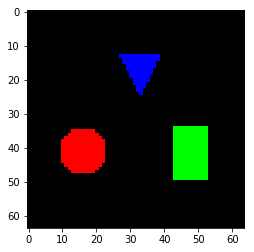

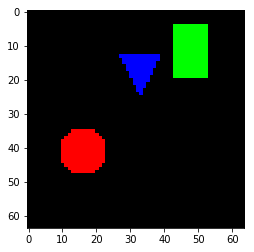

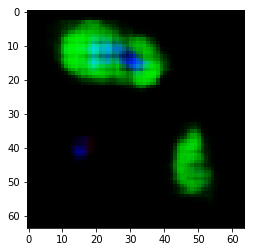

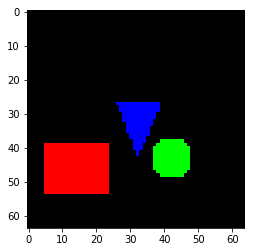

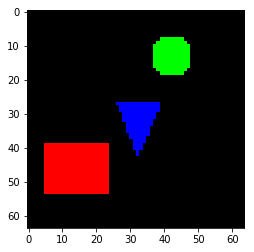

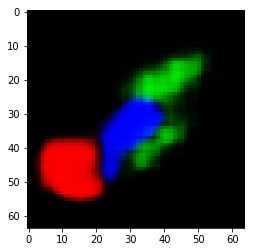

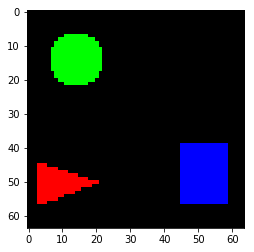

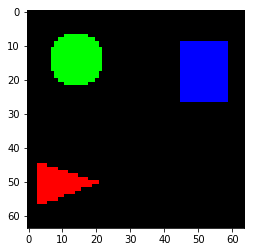

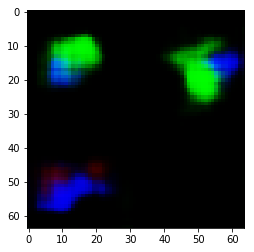

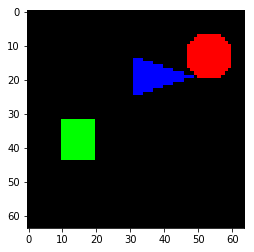

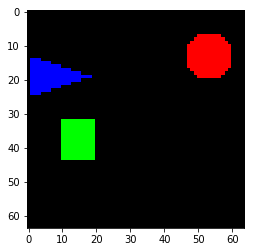

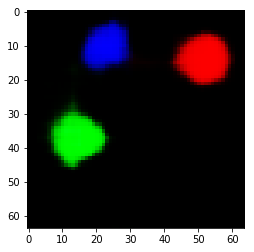

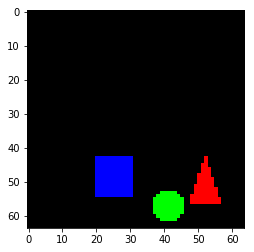

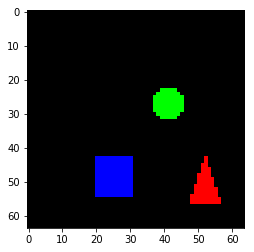

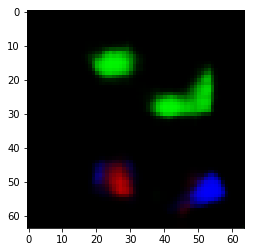

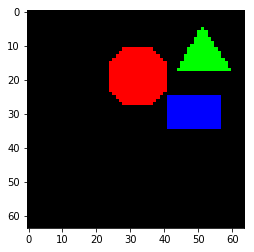

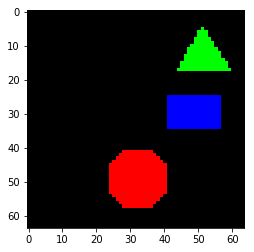

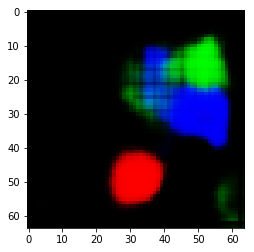

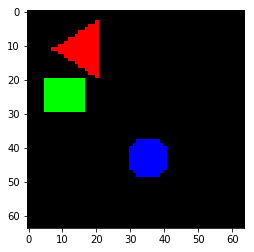

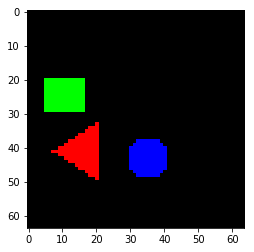

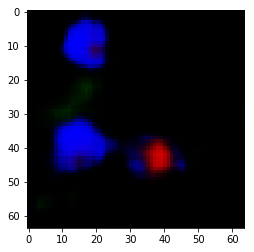

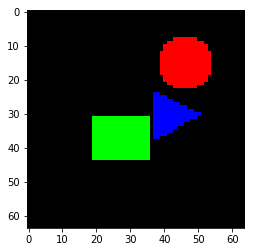

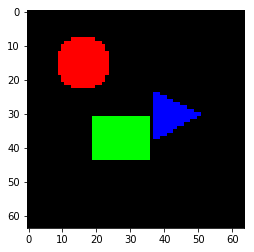

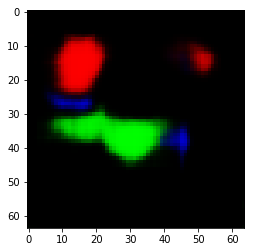

In [29]:

x_test = input_test
y_test = output_test
n = bs  # how many digits we will display
# plt.figure(figsize=(20, 4))


for i in range(n):
#     ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.array(x_test[i]*255, dtype=np.uint8))
    plt.show()
    plt.imshow(np.array(y_test[i]*255, dtype=np.uint8))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    plt.show()
    # display reconstruction
#     ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.array(decoded_imgs[i]*255, dtype=np.uint8))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    plt.show()

    
#plt.show()
plt.savefig('mnist_ae2.png')


In [24]:
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
#     print(shape)
#     print(len(shape))
    variable_parameters = 1
    for dim in shape:
#         print(dim)
        variable_parameters *= dim.value
#     print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

155693


In [30]:
saver = tf.train.Saver() 
saver.save(sess, 'train808RemakeSentMoretrain4/train808RemakeSentMoretrain4.chkp')

# Then you'll be able to access the model:

# sess = tf.Session()
# saver = tf.train.Saver()
# saver.restore(sess, 'filename.chkp')

'train808RemakeSentMoretrain4/train808RemakeSentMoretrain4.chkp'

In [14]:
# sess.close()